Data Prep

In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\nolev\Desktop\M1 Econometrics\Machine Learning\Data\tweets_cleaned.csv")

print(df.columns)
df.head()

Index(['clean_text', 'label'], dtype='object')


,clean_text,label
0,jpmorgan reel expectation beyond meat,0
1,nomura point booking weakness carnival royal c...,0
2,cemex cut credit suisse jp morgan weak buildin...,0
3,btig research cut neutral,0
4,funko slide piper jaffray pt cut,0


In [ ]:
#For binary classification
df["binary_label"] = df["label"].apply(lambda x: 0 if x == 0 else 1)
df["binary_label"].value_counts()

binary_label
1    8101
0    1442
Name: count, dtype: int64

In [ ]:
df_final = df[["clean_text", "binary_label"]].rename(columns={"binary_label": "label", "clean_text" : "text"})
df_final.head()


,text,label
0,jpmorgan reel expectation beyond meat,0
1,nomura point booking weakness carnival royal c...,0
2,cemex cut credit suisse jp morgan weak buildin...,0
3,btig research cut neutral,0
4,funko slide piper jaffray pt cut,0


Librairies Import

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import torch


c:\Users\nolev\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokenize tweets with FinBERT

In [ ]:
from transformers import BertTokenizer

# FinBERT pré-entraîné sur des textes financiers
model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
df_final["text"] = df_final["text"].astype(str)

In [ ]:

dataset = Dataset.from_pandas(df_final)

def tokenize_function(batch):
    return tokenizer(batch["text"],
                     padding="max_length",
                     truncation=True,
                     max_length = 128
                    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)



Map: 100%|██████████| 9543/9543 [00:01<00:00, 6431.03 examples/s]


In [ ]:
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Train/Test Split + Training Bert

In [ ]:
from datasets import DatasetDict


dataset_split = tokenized_dataset.train_test_split(test_size=0.25, seed=42)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=2,
    ignore_mismatched_sizes=True
)#From Hugging Face

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./finbert_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.00,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    seed=42
)


c:\Users\nolev\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
)


In [ ]:
import time

start_time = time.time()

trainer.train()

end_time = time.time()
elapsed_time = end_time - start_time
print("Execution time : {:.2f} seconds".format(elapsed_time))


Epoch,Training Loss,Validation Loss
1,0.232400,0.269567
2,0.200300,0.313830


Execution time : 250.41 seconds


Test prediction

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd


In [ ]:
predictions = trainer.predict(dataset_split["test"])

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

In [ ]:
print("Execution time : {:.2f} seconds".format(elapsed_time))
print("Scoring board :\n")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Non-negative'], digits=4))

Execution time : 250.41 seconds
Scoring board :

              precision    recall  f1-score   support

    Negative     0.7122    0.5317    0.6088       363
Non-negative     0.9196    0.9614    0.9401      2023

    accuracy                         0.8961      2386
   macro avg     0.8159    0.7466    0.7745      2386
weighted avg     0.8881    0.8961    0.8897      2386



Plotting ROC curve

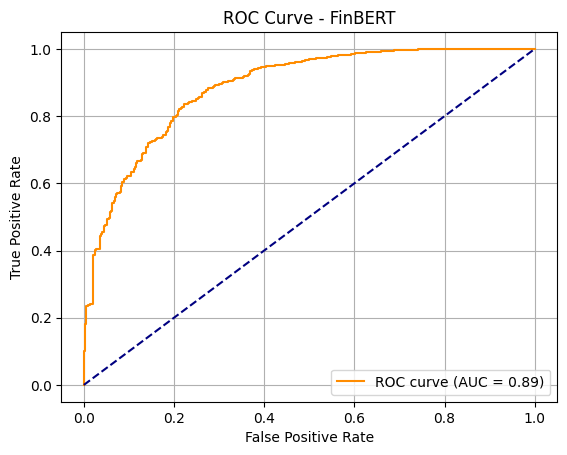

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_scores = predictions.predictions[:, 1]


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - FinBERT')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(r'C:\Users\nolev\Desktop\M1 Econometrics\Machine Learning\Outputs\roc_curve_finbert', dpi = 300)
plt.show()